# Attribute Importance for Concept Drift - Analysis on the BPI challenge 2017 dataset

The presented attribute importance evaluation framework is applied to the 2017 BPI challgen dataset. This dataset is of the loan application process of a Dutch finance institution.

## Setup
### Imports

In [1]:
# imports
import helper
import pm4py
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import pop_comparison
from processdrift.framework import windowing

### Data settings and event log loading

In [2]:
# data settings
data_file_path = 'data/real/BPI Challenge 2017.xes'

## Present basic analysis

In [3]:
# load event log
event_log = xes_importer.apply(data_file_path)

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:19<00:00, 396.83it/s]


In [4]:
# get some basic statistics (number of events, number of traces, attributes...)
basic_stats = {}

# event statistics
event_stream = pm4py.convert.convert_to_event_stream(event_log)
number_events = len(event_stream)
basic_stats['Number of events'] = number_events

event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)
print(event_attributes)
basic_stats['Event attributes'] = str(event_attributes)

number_event_attributes = len(event_attributes)
basic_stats['Number event attributes'] = number_event_attributes

# trace statistics
number_traces = len(event_log)
basic_stats['Number traces'] = number_traces

trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
print(trace_attributes)
basic_stats['Trace attributes'] = str(trace_attributes)

number_trace_attributes = len(trace_attributes)
basic_stats['Number trace attributes'] = number_trace_attributes

basic_stats_series = pd.Series(basic_stats)
basic_stats_series

{'org:resource', 'FirstWithdrawalAmount', 'concept:name', 'OfferedAmount', 'EventID', 'Selected', 'Accepted', 'MonthlyCost', 'CreditScore', 'Action', 'time:timestamp', 'OfferID', 'EventOrigin', 'NumberOfTerms'}
{'ApplicationType', 'RequestedAmount', 'LoanGoal'}


Number of events                                                     1202267
Event attributes           {'org:resource', 'FirstWithdrawalAmount', 'con...
Number event attributes                                                   14
Number traces                                                          31509
Trace attributes           {'ApplicationType', 'RequestedAmount', 'LoanGo...
Number trace attributes                                                    3
dtype: object

### Configure Primary Drift Detector

In [5]:
# alternative 1: ProDrift Drift detector
primary_process_drift_detector = drift_detection.DriftDetectorProDrift(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=200,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [6]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

# primary_feature_extractor = feature_extraction.RelationshipTypesCountFeatureExtractor('Relationship types count')
# primary_window_generator = windowing.FixedSizeWindowGenerator(window_size=150, slide_by=1)
# primary_population_comparer = pop_comparison.HotellingsTSquaredPopComparer()
# primary_threshold = 0.5
# primary_process_drift_detector = drift_detection.DriftDetector(primary_feature_extractor, 
#                                                                primary_window_generator,
#                                                                primary_population_comparer, 
#                                                                threshold=primary_threshold)

In [7]:
# alternative 3: drift detector true known
# primary_process_drift_detector = drift_detection.DriftDetectorTrueKnown(helper.get_change_points_maardji_et_al_2013(10000))

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [8]:
secondary_window_generator = windowing.FixedSizeWindowGenerator(200, slide_by=10)
secondary_population_comparer = pop_comparison.KSTestPopComparer()
secondary_threshold = 0.05
secondary_exclude_attributes = ['concept:name']
secondary_drift_detectors = drift_detection.get_all_attribute_drift_detectors(event_log,
                                                                         secondary_window_generator, 
                                                                         secondary_population_comparer,
                                                                         level='trace_and_event',
                                                                         threshold=secondary_threshold,
                                                                         exclude_attributes=secondary_exclude_attributes,
                                                                         min_observations_below=3)

## Run the Change Point Explainer

In [9]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
primary_and_secondary_changes = drift_explainer.get_primary_and_secondary_changes(event_log, max_distance=200)

exporting log, completed traces :: 100%|██████████| 31509/31509 [01:16<00:00, 412.06it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpzcnyojm0\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 655 (Wed Jan 27 14:12:29 CET 2016) after reading 723 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 2087 (Mon Feb 22 08:24:42 CET 2016) after reading 2193 traces.\r\n\r\n\r\n(3) Sudden drift detected at trace: 2390 (Wed Feb 24 14:51:54 CET 2016) after reading 2480 traces.\r\n\r\n\r\n(4) Sudden drift detected at trace: 2674 (Mon Feb 29 08:01:00 CET 2016) after reading 2714 traces.\r\n\r\n\r\n(5) Sudden drift detected at trace: 2850 (Mon Feb 29 11:04:43 CET 2016) after reading 3548 traces.\r\n\r\n\r\n(6) Sudden drift detected at trace: 4849 (Thu Mar 24 08:00:35 CET 2016) after reading 5550 traces.\r\n\r\n\r\n(7) Sudden drift detected at trace: 6522 (Fri Apr 15 08:00:34 CEST 2016) after readi

KeyError: "None of [Int64Index([578, 798, 1908, 3018, 4678, 6588], dtype='int64')] are in the [index]"

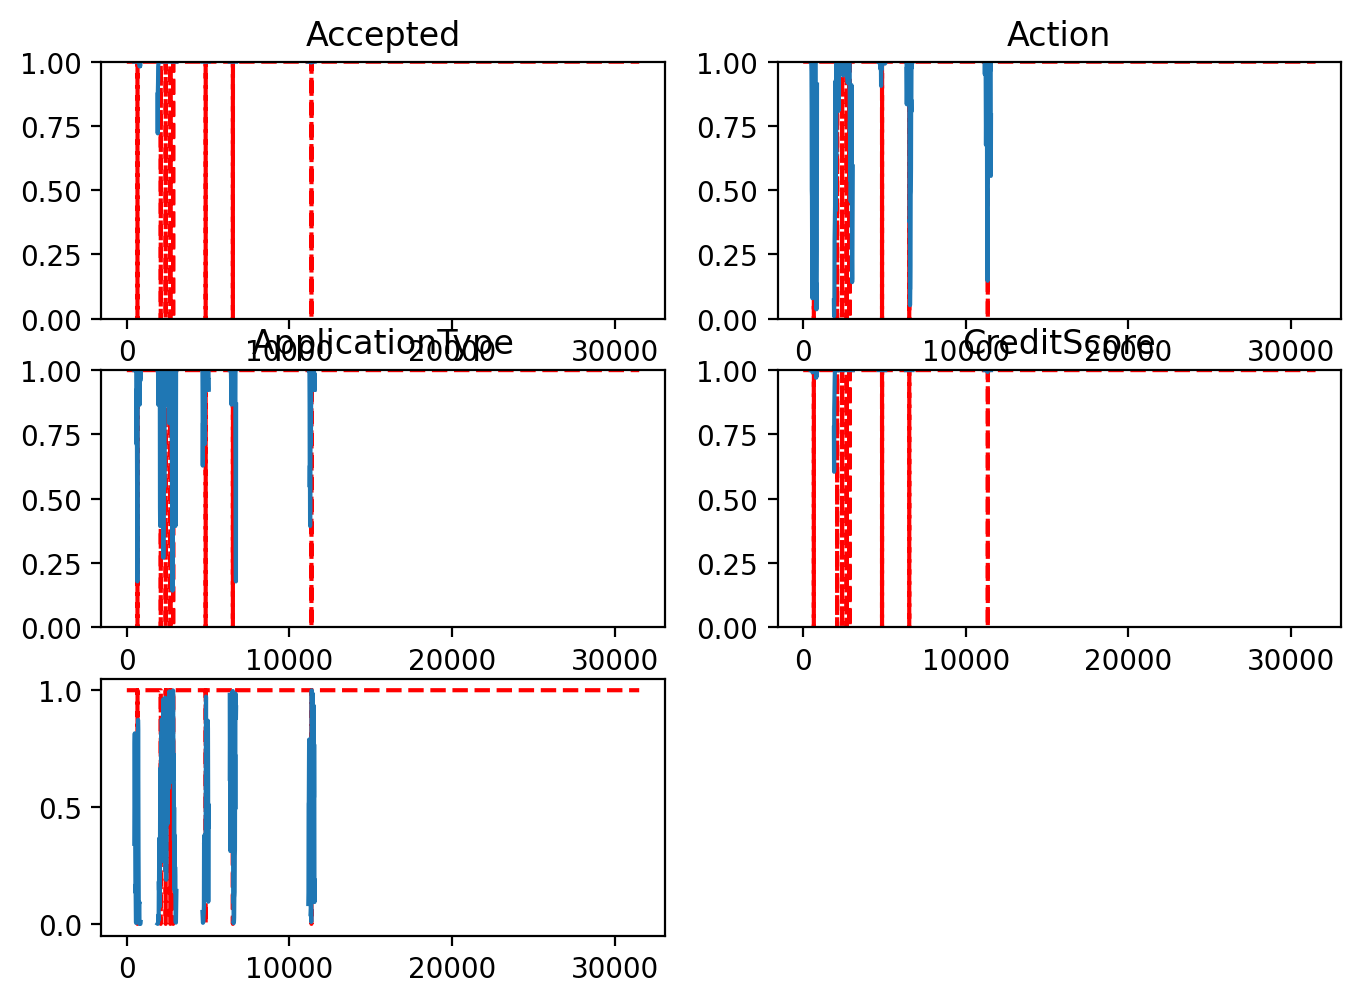

In [10]:
# plot the change point explanations
drift_explanation.plot_primary_and_secondary_changes(primary_and_secondary_changes)
pass

In [13]:
drift_explanation.attribute_importance_per_primary_change_point(primary_and_secondary_changes, max_distance=200)

{655: [{'detector': 'EventID', 'change_point': 578, 'distance': -77},
  {'detector': 'EventID', 'change_point': 798, 'distance': 143},
  {'detector': 'EventOrigin', 'change_point': 808, 'distance': 153},
  {'detector': 'org:resource', 'change_point': 478, 'distance': -177}],
 2087: [{'detector': 'EventID', 'change_point': 1908, 'distance': -179},
  {'detector': 'EventOrigin', 'change_point': 1908, 'distance': -179},
  {'detector': 'OfferID', 'change_point': 1908, 'distance': -179},
  {'detector': 'org:resource', 'change_point': 1908, 'distance': -179}],
 2390: [{'detector': 'LoanGoal', 'change_point': 2568, 'distance': 178}],
 2674: [{'detector': 'LoanGoal', 'change_point': 2688, 'distance': 14},
  {'detector': 'LoanGoal', 'change_point': 2568, 'distance': -106},
  {'detector': 'time:timestamp', 'change_point': 2838, 'distance': 164}],
 2850: [{'detector': 'time:timestamp', 'change_point': 2838, 'distance': -12},
  {'detector': 'LoanGoal', 'change_point': 2688, 'distance': -162},
  {'d